# Stiefel optimization with higher number of sites. Does the error change?

In [1]:
import numpy as np
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from jax import config
config.update("jax_enable_x64", True)

In [2]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, super2ortho, create_trotter_layers
d, N, gamma = 2, 6, 1
tau = 4

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec, Lvec_odd, Lvec_even], tau=tau)

In [3]:
from opentn.optimization import frobenius_norm, model_stiefel_local, get_kitaev_trotter_local_ansatz
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec

xs_rank_2_sites_6 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=1)]

f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')


In [4]:
# initial cost function with stiefel ansatz for two sites
f_stiefel(xs_rank_2_sites_6)

DeviceArray(0.53944709, dtype=float64)

In [5]:
# checking if the stiefel model is correct.
frobenius_norm(exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd, exp_Lvec)

In [41]:
# checking the operator sizes
[op.shape for op in xs_rank_2_sites_6] # as expected 4,4,2 (out, in, rank)
# NOTE: the rank does not change even if I don't enforce it for this 2 site noise

[(8, 4), (8, 4), (8, 4)]

In [17]:
# optimization for this (only 10 iterations because it takes already a lot)
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
from opentn.stiefel import retract_stiefel

xs_rank_2_sites_6_opt, f_rank_2_sites_6_opt, _, radius_rank_2_sites_6_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_rank_2_sites_6, save_x=True, niter=1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02


In [21]:
xs_rank_2_sites_6_opt_2, f_rank_2_sites_6_opt_2, _, radius_rank_2_sites_6_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_rank_2_sites_6_opt[-1], save_x=True, niter=2, radius_init=radius_rank_2_sites_6_opt
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02


In [35]:
f_rank_2_sites_6_opt_2, f_stiefel(xs_rank_2_sites_6_opt_2[-1])

([DeviceArray(0.44603396, dtype=float64),
  DeviceArray(0.43118643, dtype=float64)],
 DeviceArray(0.43116507, dtype=float64))

In [25]:
f_sites_6_opt = f_rank_2_sites_6_opt + f_rank_2_sites_6_opt_2 + [f_stiefel(xs_rank_2_sites_6_opt_2[-1])]

0.7992722148121031


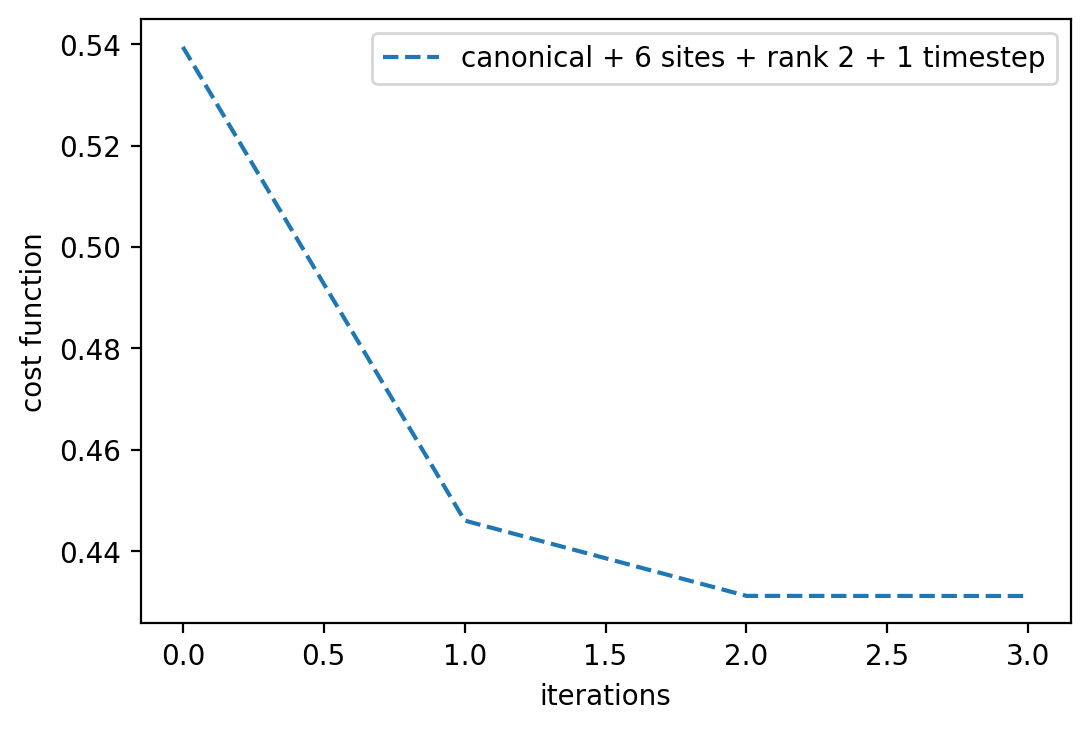

In [27]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.plot(f_sites_6_opt, '--', label='canonical + 6 sites + rank 2 + 1 timestep')
plt.legend()
print(f_sites_6_opt[-1]/f_sites_6_opt[0])

In [36]:
# get the initial and final gradients
initial_grad = grad_stiefel(xs_rank_2_sites_6) 
final_grad = grad_stiefel(xs_rank_2_sites_6_opt_2[-1])

In [38]:
# check their norms. The initial one should be way higher than final based on optimization graph
initial_norm = np.linalg.norm(initial_grad)
final_norm = np.linalg.norm(final_grad)
initial_norm, final_norm

(15.82062161395626, 0.0002505223124160928)

In [ ]:
# as expected. So it seems to be working in the beginning and then it just quickly doesn't.
# but why is it so fast? even faster than for lower number of sites ...
# here the optimization basically finished after 3 iterations! Well, to be fair the one for the 4 sites
# with og rank of 2 also finishes after 

In [16]:
hessian_stiefel(xs_rank_2_sites_6)

column : 0


KeyboardInterrupt: 

In [39]:
# let me now try to do the optimization but for higher number of layers!
# let's do 2 time steps (5 layers) and compare with lower sites.
xs_rank_2_sites_6_timesteps_2 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=2)]
# initial cost function should be better than before
f_stiefel(xs_rank_2_sites_6_timesteps_2)

DeviceArray(0.13842033, dtype=float64)

In [43]:
xs_rank_2_sites_6_opt_timesteps_2, f_rank_2_sites_6_opt_timesteps_2, _, radius_rank_2_sites_6_opt_timesteps_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_rank_2_sites_6_timesteps_2, save_x=True, niter=2
)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
column : 3


In [1]:
f_rank_2_sites_6_opt_timesteps_2

NameError: name 'f_rank_2_sites_6_opt_timesteps_2' is not defined